In [1]:
!pip install  mysql-connector-python

In [2]:
# Importing necessary libraries
import datetime
import warnings

import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector.connection import MySQLConnection
import pandas as pd

warnings.filterwarnings('ignore')

In [3]:
# Creating a connecting to database
con = mysql.connector.connect(user='', password='',
                             host='', 
                             database='employees')

#### 1. Find the maximum and minimum dates for hiring employees

In [5]:
# Set a cursor to interact with the database
cursor = con.cursor() 

In [6]:
# SQL query to retrieve the maximum and minimum hire dates from the employees table
sql = """
SELECT max(hire_date), min(hire_date)
FROM employees
"""

In [7]:
# Execute the SQL query using the cursor
cursor.execute(sql)

# Fetch all rows of the result and output them
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

#### 2. We aim to retrieve the most recent salary information for each employee in the database.

Key Considerations:

1. Salaries can be updated multiple times within the same day. For example, an employee may have a salary update on a specific day, such as 2001-01-01, followed by another update on the same day. The query must account for these cases.
2. Salary values can decrease over time. Therefore, selecting the salary with the maximum value for a given date is incorrect from a business logic perspective.
3. The query should accurately reflect the latest historical salary value for each employee.

This ensures the output represents the correct and most recent salary data for all employees in the database.

In [9]:
# Set the cursor again
cursor = con.cursor()

In [10]:
# SQL query to retrieve info about l
sql_last_salary = """
SELECT emp_no, 
       salary, 
       from_date, 
       to_date
FROM employees.salaries s1
WHERE to_date = (
    SELECT MAX(s2.to_date)
    FROM employees.salaries s2
    WHERE s1.emp_no = s2.emp_no
);
"""

In [11]:
# Execute the SQL query using the cursor
cursor.execute(sql_last_salary)

# Convert the fetched data from the cursor into a pandas DataFrame
res = pd.DataFrame(
    cursor.fetchall(),  # Fetch all rows from the executed SQL query
    columns=('emp_no', 'salary', 'from_date', 'to_date')  # Define column names 
)

# Extract the field names (column names) from the cursor description
field_names = [i[0] for i in cursor.description] 

# Display the DataFrame's column names, shape (rows and columns), and the first 3 rows
print(f'Columns name: {res.columns}')
print(f'Shape of DataFrame: {res.shape}') 
display(res[:3])

Columns name: Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')
Shape of DataFrame: (300180, 4)


,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


#### 3. Find in the res variable how many values to_date are equal to 9999-01-01 and how many are not? 

In [13]:
res.dtypes

emp_no        int64
salary        int64
from_date    object
to_date      object
dtype: object

In [14]:
res.to_date[0]

datetime.date(9999, 1, 1)

In [15]:
# Filter rows where the 'to_date' column equals '9999-01-01' (indicating current employees)
filter = res.to_date == datetime.date(9999, 1, 1)

# Create a DataFrame containing only rows for employees still working (to_date = '9999-01-01')
working_staff = res[filter]

# Print the count of rows where 'to_date' equals '9999-01-01'
print(f'{working_staff.to_date.count()} records have to_date equal to 9999-01-01')

# Filter rows where 'to_date' is NOT equal to '9999-01-01'
filter1 = res.to_date != datetime.date(9999, 1, 1)

# Print the count of rows where 'to_date' does NOT equal '9999-01-01'
print(f'{res[filter1].to_date.count()} records have to_date not equal to 9999-01-01')

# Print the total number of employees who are still working
print(f"Number of employees still working: {len(working_staff)}")

240124 records have to_date equal to 9999-01-01
60056 records have to_date not equal to 9999-01-01
Number of employees still working: 240124


#### 4. Visualize the distribution (histogram) of salaries of employees who are still working in the company, using the result of the previous task. Employees who are still working in the company are those whose to_date is 9999-01-01. 

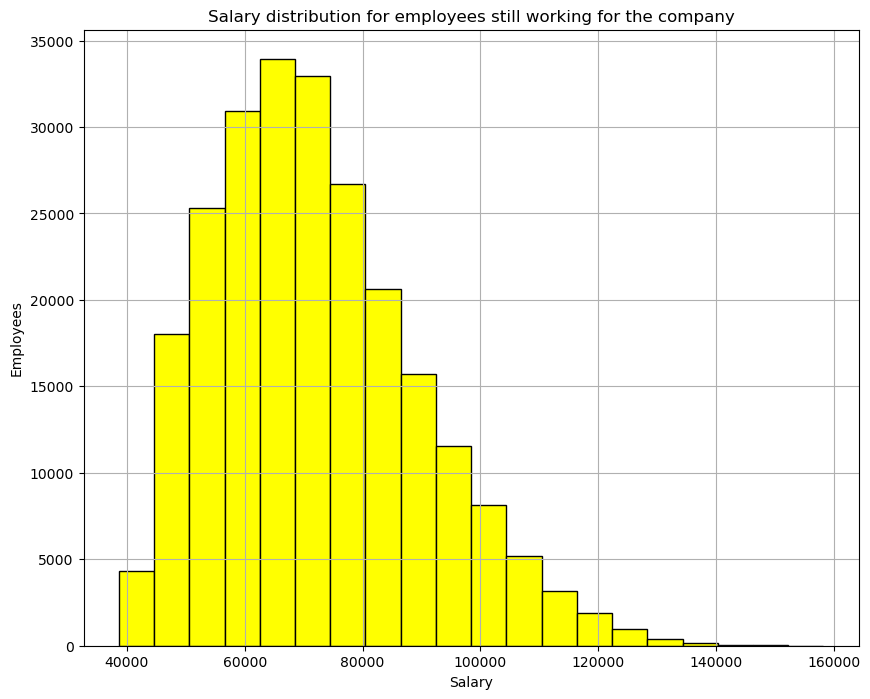

In [17]:
# Create a histogram to visualize the salary distribution of currently employed staff
working_staff['salary'].hist(
    figsize=(10, 8),  # Set the size of the plot (width, height)
    bins=20,          # Divide the salary range into 20 bins
    color='yellow',   # Set the color of the bars to yellow
    edgecolor='black' # Add black edges to the bars for better visibility
)

# Add a title to the histogram
plt.title('Salary distribution for employees still working for the company')

# Label the x-axis with 'Зарплата' to indicate the salary range
plt.xlabel('Salary')

# Label the y-axis with 'Кількість працівників' to show the number of employees in each bin
plt.ylabel('Employees');

#### 5. Display the number of employees using pandas.read_sql by the year in which they were hired (hire_date). 

In [19]:
# SQL query to find employees number by hire year
employees_year = """
SELECT YEAR(hire_date)  as hire_year, 
        COUNT(emp_no) as amount_employees 
FROM employees 
GROUP BY YEAR(hire_date)
ORDER BY hire_year ASC
"""

In [20]:
# Write the sql query results to the df variable
df = pd.read_sql(employees_year, con)
df

,hire_year,amount_employees
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


#### 6. Draw a linear graph of the relation between the number of employees and the year of hiring.

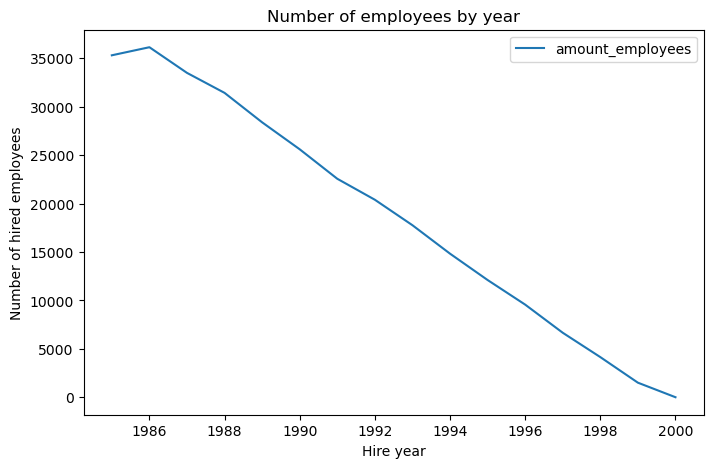

In [22]:
# Plotting the number of hired employees over the years using a line chart
df.plot(
    'hire_year',             # Column for the x-axis (year of hire)
    'amount_employees',      # Column for the y-axis (number of employees hired)
    figsize=(8, 5)           # Set the size of the plot (width=8, height=5)
)

# Adding a title to the plot to describe what it represents
plt.title('Number of employees by year')

# Labeling the x-axis with 'Рік найму' to indicate it represents the hiring year
plt.xlabel('Hire year')

# Labeling the y-axis with 'Кількість найманих працівників' to show the number of employees hired
plt.ylabel('Number of hired employees');

#### We see a downward trend in hiring new employees every year. This may be due to either migration between departments or long tenure in the company, which indicates a good company policy towards its employees.

#### 7.Using SQL, for employees in the Engineer position who no longer work in the company (that is, they have a to_date value that is not filled with the default value), find the number of full years in the position. 

In [25]:
# SQL query for finding the number of working years for those employees who no longer work in the company
eng_diff_year = """
SELECT 
    emp_no,
    from_date,
    to_date,
    TIMESTAMPDIFF (YEAR, from_date, to_date) as work_year
FROM titles 
WHERE title = "Engineer" AND to_date != "9999-01-01"
"""

In [26]:
# Writting result to variable
df_years = pd.read_sql(eng_diff_year, con)

#Print the result
df_years

,emp_no,from_date,to_date,work_year
0,10004,1986-12-01,1995-12-01,9
1,10009,1990-02-18,1995-02-18,5
2,10012,1992-12-18,2000-12-18,8
3,10018,1987-04-03,1995-04-03,8
4,10026,1995-03-20,2001-03-19,5
...,...,...,...,...
84015,499972,1989-11-23,1998-11-23,9
84016,499984,1989-07-30,1994-07-30,5
84017,499994,1993-02-22,1993-10-27,0
84018,499996,1996-05-13,2002-05-13,6


#### 8. Using the data in df_years, create a bar graph of the number of years people with the position title Engineer have been in the position. 

In [28]:
# Display unique values in the 'work_year' column to understand the range of years employees have worked
df_years['work_year'].unique()

array([9, 5, 8, 6, 7, 1, 0, 3, 2, 4])

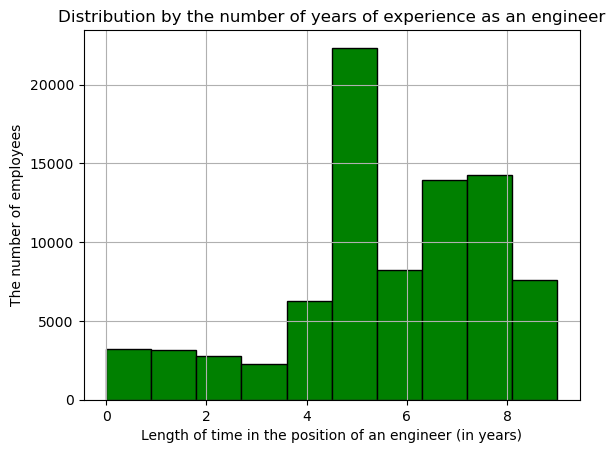

In [29]:
# Create a histogram to visualize the distribution of years worked as an engineer
df_years['work_year'].hist(
    bins=10,              # Divide the range of years into 10 bins for grouping
    color='green',        # Set the color of the bars to green
    edgecolor='black'     # Add black edges to the bars for better visibility
)

# Add a title to the histogram to describe the distribution it represents
plt.title('Distribution by the number of years of experience as an engineer')

# Label the x-axis to indicate it represents the duration of time spent in the position (in years)
plt.xlabel('Length of time in the position of an engineer (in years)')

# Label the y-axis to show the number of employees for each bin of years worked
plt.ylabel('The number of employees');

In [30]:
# Close the database connection to free up resources
con.close()